C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-12 21:57:57,506] A new study created in memory with name: no-name-9a9318f0-655b-4d88-a02a-941c0d9c7c57
[I 2024-09-12 21:59:13,444] Trial 0 finished with value: 0.025181395933032036 and parameters: {'n_layers': 3, 'units': 150}. Best is trial 0 with value: 0.025181395933032036.
[I 2024-09-12 21:59:32,546] Trial 1 finished with value: 0.023020051419734955 and parameters: {'n_layers': 2, 'units': 88}. Best is trial 1 with value: 0.023020051419734955.
[I 2024-09-12 22:00:02,415] Trial 2 finished with value: 0.028927115723490715 and parameters: {'n_layers': 3, 'units': 87}. Best is trial 1 with value: 0.023020051419734955.
[I 2024-09-12 22:01:27,768] Trial 3 finished with value: 0.02495385892689228 and parameters: {'n_

Best parameters: {'n_layers': 2, 'units': 127}
Epoch 1/100
25/25 [==============================] - 6s 140ms/step - loss: 0.0039 - val_loss: 0.0674
Epoch 2/100
25/25 [==============================] - 3s 118ms/step - loss: 7.1884e-04 - val_loss: 0.0310
Epoch 3/100
25/25 [==============================] - 3s 117ms/step - loss: 5.3997e-04 - val_loss: 0.0367
Epoch 4/100
25/25 [==============================] - 3s 118ms/step - loss: 5.0201e-04 - val_loss: 0.0532
Epoch 5/100
25/25 [==============================] - 3s 118ms/step - loss: 4.8101e-04 - val_loss: 0.0517
Epoch 6/100
25/25 [==============================] - 3s 118ms/step - loss: 4.6549e-04 - val_loss: 0.0366
Epoch 7/100
25/25 [==============================] - 3s 117ms/step - loss: 3.7502e-04 - val_loss: 0.0361
Epoch 8/100
25/25 [==============================] - 3s 117ms/step - loss: 4.8847e-04 - val_loss: 0.0206
Epoch 9/100
25/25 [==============================] - 3s 118ms/step - loss: 4.8114e-04 - val_loss: 0.0259
Epoch 10/100

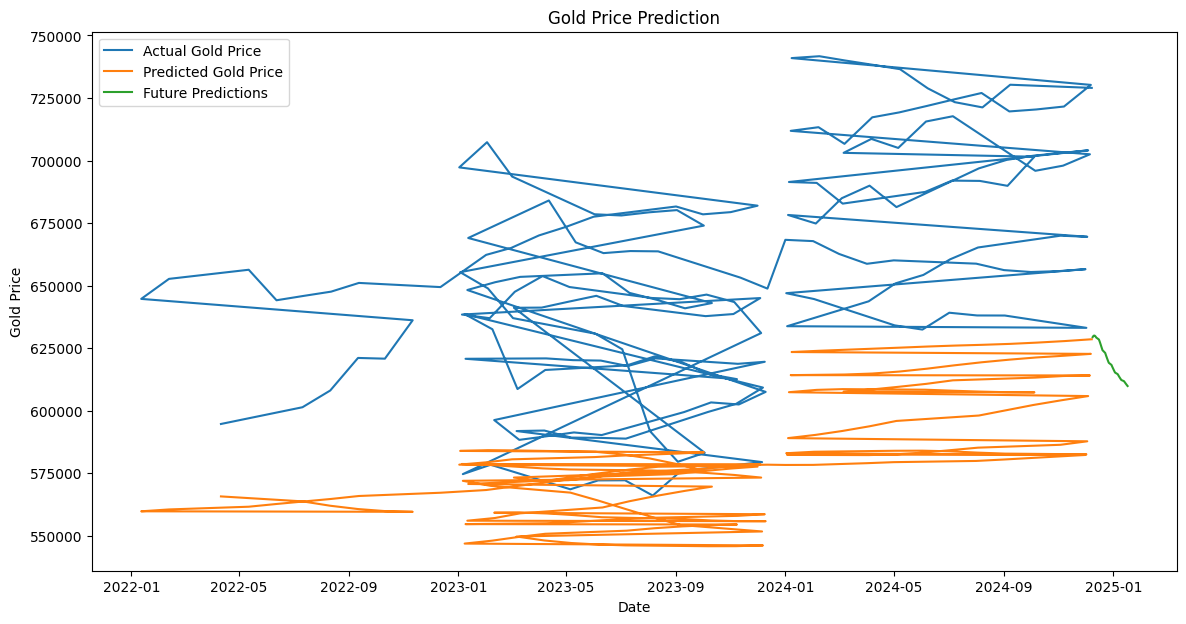

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Assuming your dataset is already a CSV file

# Check if 'date' column exists
if 'date' not in df.columns:
    raise KeyError("'date' column not found. Make sure your dataset includes a 'date' column.")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Handle any invalid date formats (e.g., NaT values)
df = df.dropna(subset=['date'])

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the model with LSTM and Attention
def create_model(n_layers, units):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers
    lstm_out = LSTM(units=units, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)
    for _ in range(n_layers - 1):
        lstm_out = LSTM(units=units, return_sequences=True)(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(units=units)(concat)
    lstm_out = Dropout(0.2)(lstm_out)
    output_layer = Dense(units=1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 50, 200)
    
    model = create_model(n_layers, units)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

# Build and train the final model with the best parameters
best_n_layers = study.best_params['n_layers']
best_units = study.best_params['units']

model = create_model(best_n_layers, best_units)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for 30 days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()
